In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import or_

from app.models import Session, Headline, Article, Agency
from app.utils import Country, Config

In [2]:
s = Session()
data = s.query(
    Headline.id, Article.id, Agency.name, Headline.processed, Headline.first_accessed, Headline.last_accessed
).join(Headline.article).join(Article.agency).filter(
    or_(Agency._country == Country.us.value, Agency.name.in_(Config.exempted_foreign_media))
).all()
s.close()

In [3]:
raw_df = pd.DataFrame(data, columns=['hid', 'aid', 'agency', 'title', 'first', 'last'])
print(raw_df.shape)

(741545, 6)


In [4]:
from tqdm import tqdm

tqdm.pandas()
# Take only the first 1000 rows for now
# df = raw_df.head(10000).copy()
df = raw_df.copy()
# Convert the datetimes from utc to NY time. They're not timezone aware
df['first'] = df['first'].dt.tz_localize('utc').dt.tz_convert('America/New_York')
df['last'] = df['last'].dt.tz_localize('utc').dt.tz_convert('America/New_York')
# Get the timedelta between the first and last access
df['delta'] = df['last'] - df['first']
# Drop the rows where the delta is more than 3 days. This should filter out normal links not to real stories
df = df[df['delta'] <= pd.Timedelta(days=3)]

In [5]:
# filtering by us and exempted media really improves this!
def get_hours(row):
    first = row['first']
    last = row['last']
    # Zero out the minutes and seconds
    first_ts = first.replace(minute=0, second=0, microsecond=0).timestamp()
    last_ts = last.replace(minute=0, second=0, microsecond=0).timestamp()
    # get every half hour between the first and last access
    hours = np.arange(first_ts, last_ts, 1800, dtype=int)
    # Filter out the hours that are not in the same day as the first access
    return hours[(hours <= last_ts) & (hours >= first_ts)]
    
df['halfhour'] = df.progress_apply(get_hours, axis=1)

100%|██████████| 701843/701843 [00:21<00:00, 32416.05it/s]


In [6]:
# Next we explode the hours column so that each row corresponds to a single hour
df = df.explode('halfhour')
# Reset the index
df.reset_index(drop=True, inplace=True)
# Convert the hours column to a datetime
df['halfhour'] = pd.to_datetime(df['halfhour'], unit='s')
df = df[['title', 'halfhour']]

In [7]:
df.sample(5)

,title,halfhour
8048260,"Under budget pressure, D. C. public schools ma...",2024-04-16 09:30:00
5142960,Marjorie Taylor Greene files motion to oust Ho...,2024-03-24 23:30:00
7131119,"Half Moon, Small Cloud",2024-04-10 05:30:00
7079642,Why more Americans are making hardship withdra...,2024-04-08 06:00:00
308023,Ukrainian forces don't have enough artillery t...,2024-02-19 03:30:00


In [8]:
# Group by the hours column and apply the get_newsiness function to the titles
# Eventually we can speed this up with multiprocessing I think.
# For now though, this is fine. More than a million headlines Seems to be taking under 20 minutes.
# Recalculation will be expensive! But we won't do it often.
# We'll save the results as a csv for incorporation in the website.
# Simple solutions are best.

import multiprocessing as mp
from app.analysis.newsiness import get_newsiness

titles_by_hour = [group["title"].tolist() for _, group in df.groupby('halfhour')]
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.imap(get_newsiness, titles_by_hour)
    newsiness = list(tqdm(results, total=len(titles_by_hour)))


# It took almost 22 minutes for the first run.
# newsiness = df.groupby('hours')['title'].progress_apply(get_newsiness)


100%|██████████| 4944/4944 [00:55<00:00, 88.52it/s] 


In [9]:
# Create a dataframe from the groupby object and add a column of the newsiness
newsiness_df = df.groupby('halfhour').first().reset_index()
newsiness_df = newsiness_df[['halfhour']]
newsiness_df['newsiness'] = newsiness
newsiness_df.head()

,halfhour,newsiness
0,2024-02-16 20:00:00,2.750258
1,2024-02-16 20:30:00,2.750258
2,2024-02-16 21:00:00,2.501889
3,2024-02-16 21:30:00,2.501889
4,2024-02-16 22:00:00,2.610354


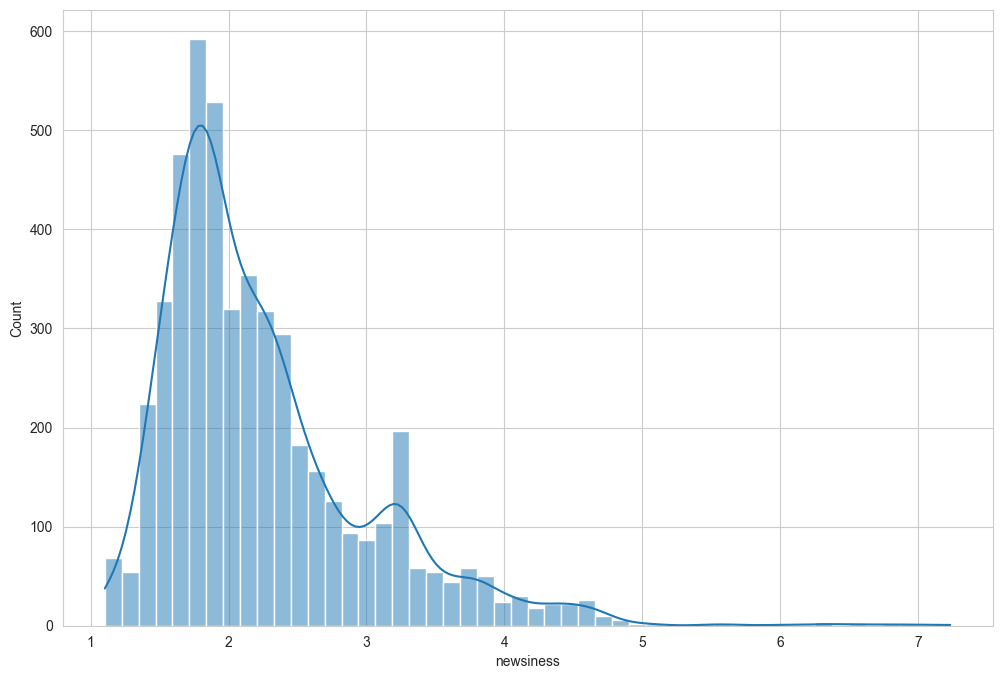

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot a histogram of the newsiness
plt.figure(figsize=(12, 8))
sns.histplot(newsiness_df['newsiness'], bins=50, kde=True)
plt.show()


In [11]:
# Get some statistics
newsiness_df['newsiness'].describe()

count    4944.000000
mean        2.248278
std         0.754206
min         1.102908
25%         1.741173
50%         2.035292
75%         2.547218
max         7.233907
Name: newsiness, dtype: float64

In [12]:
# Let's sample some headlines from the highest newsiness hour
df[df['halfhour'] == newsiness_df[newsiness_df['newsiness'] == newsiness_df['newsiness'].max()]['halfhour'].values[0]].sample(10)

,title,halfhour
13840148,"Gold Does Not Reflect Monetary Destruction, Yet",2024-05-20 15:00:00
13856312,Political Debates Are Exacerbating the Mental ...,2024-05-20 15:00:00
13884454,Teen resuscitated from cardiac arrest after dr...,2024-05-20 15:00:00
13883249,Michael Cohen admits he 'stole from the Trump ...,2024-05-20 15:00:00
13883747,'SNL' host Colin Jost forced to make awkward j...,2024-05-20 15:00:00
13781566,Talking to Voters in Idaho District 10,2024-05-20 15:00:00
13863351,What could have been hangs over Scottie Scheff...,2024-05-20 15:00:00
13606984,Fight against antisemitism may have deep-pocke...,2024-05-20 15:00:00
13718807,I'd Given Up on Home Manicures--Until I Found ...,2024-05-20 15:00:00
13878665,There's another word for Manchester City's dom...,2024-05-20 15:00:00


In [13]:
# Now create a column of the day of the week
newsiness_df['day'] = newsiness_df['halfhour'].dt.day_name()
# Convert the "hours" column, which is actually halfhour to the hour of the day to an integer representing the 24 hour clock (00, 30, 60, 90, etc)
newsiness_df['halfhour'] = newsiness_df['halfhour'].dt.hour * 60 + newsiness_df['halfhour'].dt.minute

# Create a df of group by hour and day and take the mean of the newsiness and the median of the newsiness
newsiness_df = newsiness_df.groupby(['halfhour', 'day'])['newsiness'].agg(['mean', 'median', 'std']).reset_index()
newsiness_df.head()

,halfhour,day,mean,median,std
0,0,Friday,1.944051,1.883297,0.523492
1,0,Monday,2.470418,2.327633,0.732713
2,0,Saturday,2.426204,2.157310,0.779183
3,0,Sunday,2.258861,2.126182,0.685218
4,0,Thursday,2.203444,2.055255,0.595075


In [14]:
newsiness_df.to_csv('../newsiness.csv', index=False)

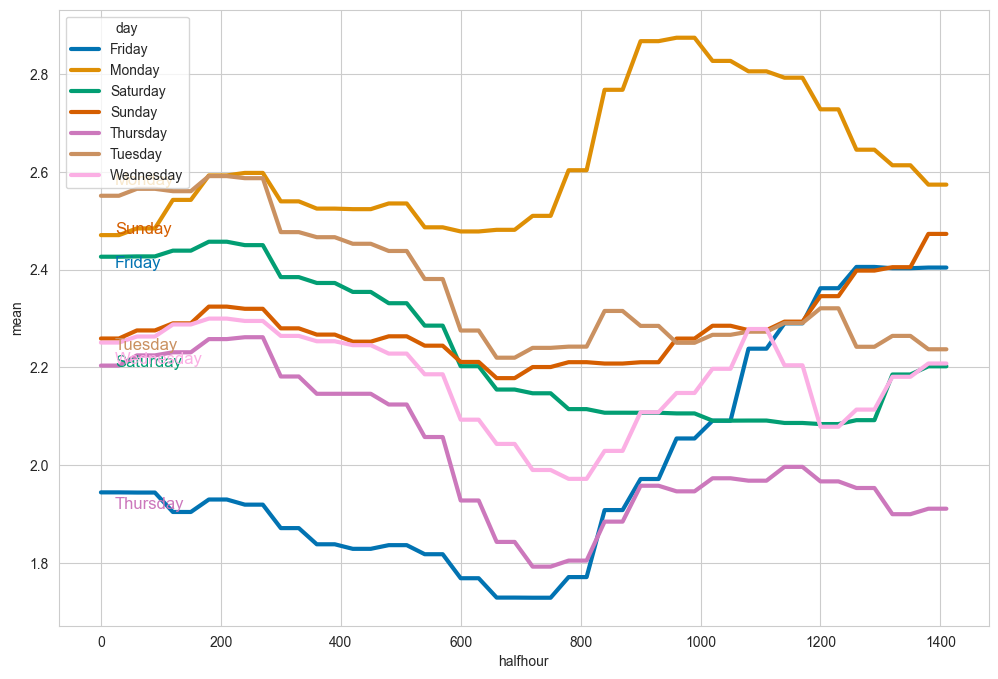

In [15]:
# Plot the mean newsiness by hour
import seaborn as sns
import matplotlib.pyplot as plt

# Colorblind friendly
sns.set_palette('colorblind')
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='halfhour', y='mean', hue='day', lw=3)
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['mean'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()

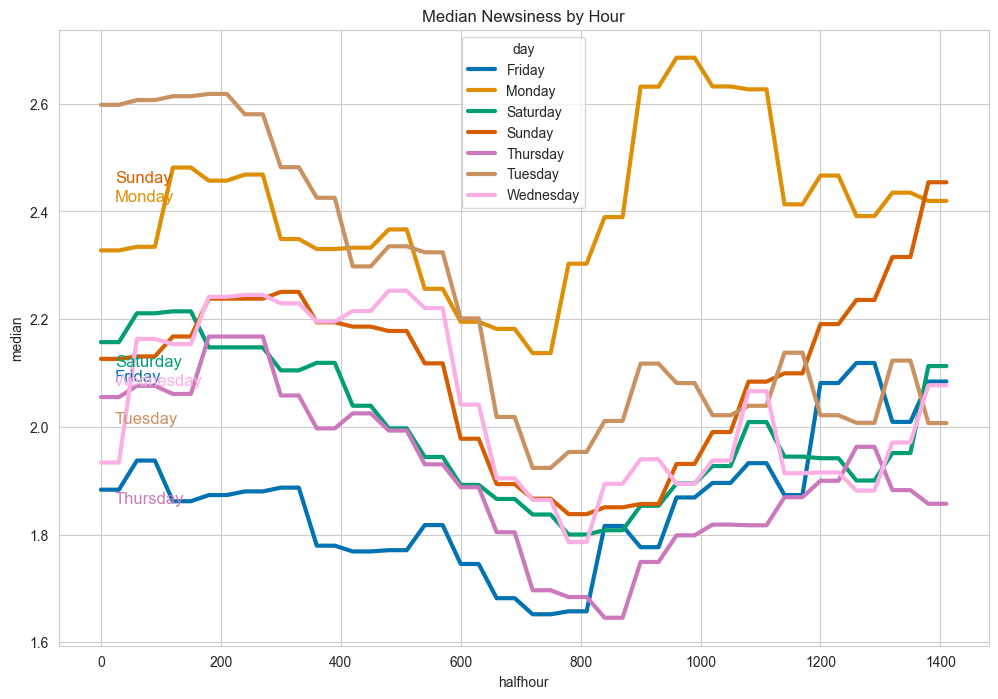

In [16]:
# Plot the median newsiness by hour
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='halfhour', y='median', hue='day', lw=3)
# Add a title
plt.title('Median Newsiness by Hour')
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['median'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()


In [17]:
# Rank the days by newsiness
newsiness_df.groupby('day')['mean'].mean().sort_values(ascending=False)

day
Monday       2.619289
Tuesday      2.366199
Sunday       2.280249
Saturday     2.237251
Wednesday    2.175539
Thursday     2.027190
Friday       1.998047
Name: mean, dtype: float64

In [18]:
# Rank the hours by newsiness
newsiness_df.groupby('halfhour')['mean'].mean().sort_values(ascending=False)

halfhour
180     2.350206
210     2.350206
240     2.347061
270     2.347061
120     2.321936
150     2.321936
60      2.311785
90      2.311785
0       2.300643
30      2.300643
1380    2.286829
1410    2.286829
330     2.285202
300     2.285202
1140    2.278960
1170    2.278960
1350    2.278594
1320    2.278594
1080    2.275657
1110    2.275657
1230    2.269200
1200    2.269200
390     2.266710
360     2.266710
1260    2.264062
1290    2.264062
450     2.257481
420     2.257481
510     2.250778
480     2.250778
1020    2.247074
1050    2.247074
960     2.233805
990     2.233805
900     2.215173
930     2.215173
570     2.208124
540     2.208124
870     2.174079
840     2.174079
630     2.136404
600     2.136404
810     2.102438
780     2.102438
690     2.092521
660     2.092521
750     2.086754
720     2.086754
Name: mean, dtype: float64

In [19]:
# Find the newsiest hourday
newsiness_df[newsiness_df['mean'] == newsiness_df['mean'].max()]

,halfhour,day,mean,median,std
225,960,Monday,2.87431,2.685409,1.281614
232,990,Monday,2.87431,2.685409,1.281614


In [20]:
# Group by morning, afternoon, evening, night and find the busiest period on which day
newsiness_df['period'] = pd.cut(newsiness_df['halfhour'], bins=[v * 60 for v in [0, 6, 12, 18, 24]],
                                labels=['night', 'morning', 'afternoon', 'evening'])
newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)


C:\Users\malan\AppData\Local\Temp\ipykernel_26776\93058822.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)


day        period   
Monday     afternoon    2.766180
           evening      2.682776
Tuesday    night        2.548108
Monday     night        2.542315
           morning      2.503583
Saturday   night        2.426025
Sunday     evening      2.373161
Friday     evening      2.360491
Tuesday    morning      2.353167
Sunday     night        2.291932
Wednesday  night        2.276838
Tuesday    evening      2.271029
           afternoon    2.269166
Saturday   morning      2.264457
Sunday     afternoon    2.235039
           morning      2.230389
Thursday   night        2.221651
Wednesday  evening      2.167857
           morning      2.152735
Saturday   evening      2.126251
           afternoon    2.107272
Wednesday  afternoon    2.097830
Thursday   morning      2.010989
Friday     afternoon    1.963033
Thursday   evening      1.947220
Friday     night        1.909641
Thursday   afternoon    1.907548
Friday     morning      1.793727
Name: mean, dtype: float64